### Consistency
- Assesses stability of explanations when model trained on different subsets
- Low consistency → no robust explanations

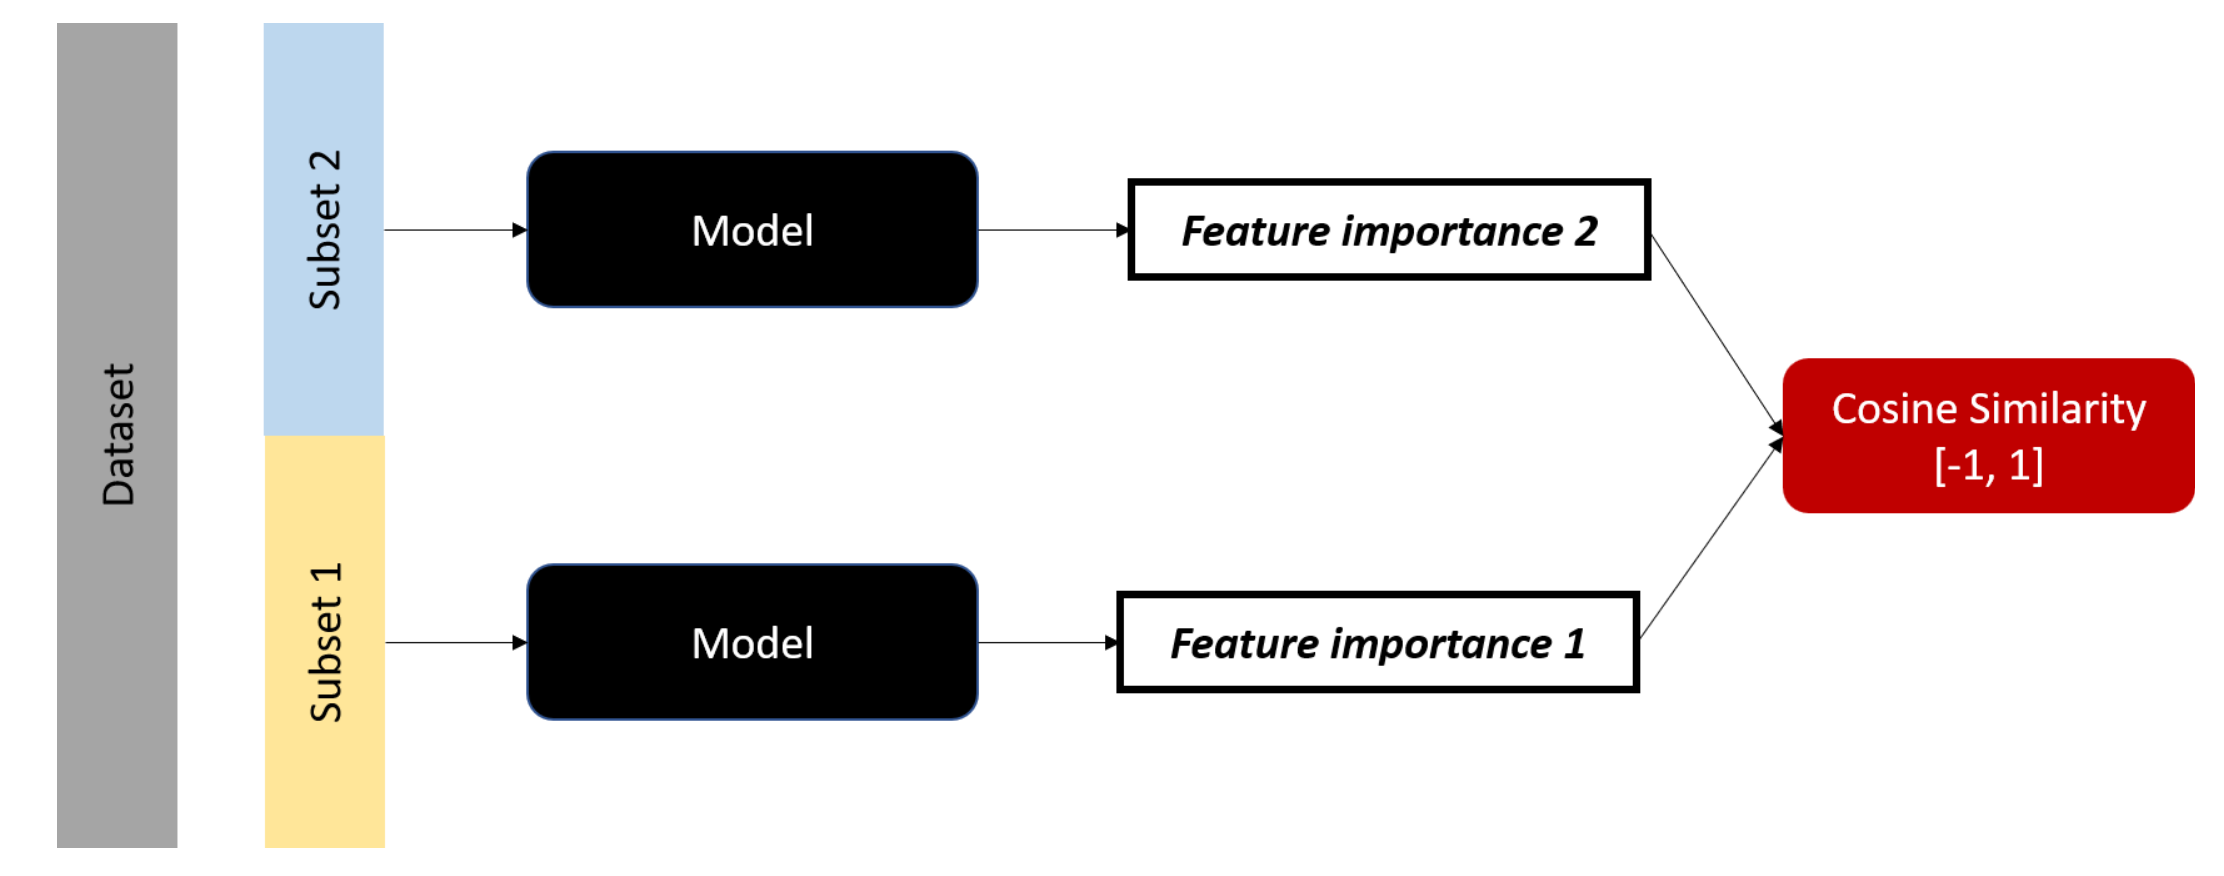

### Cosine similarity to measure consistency

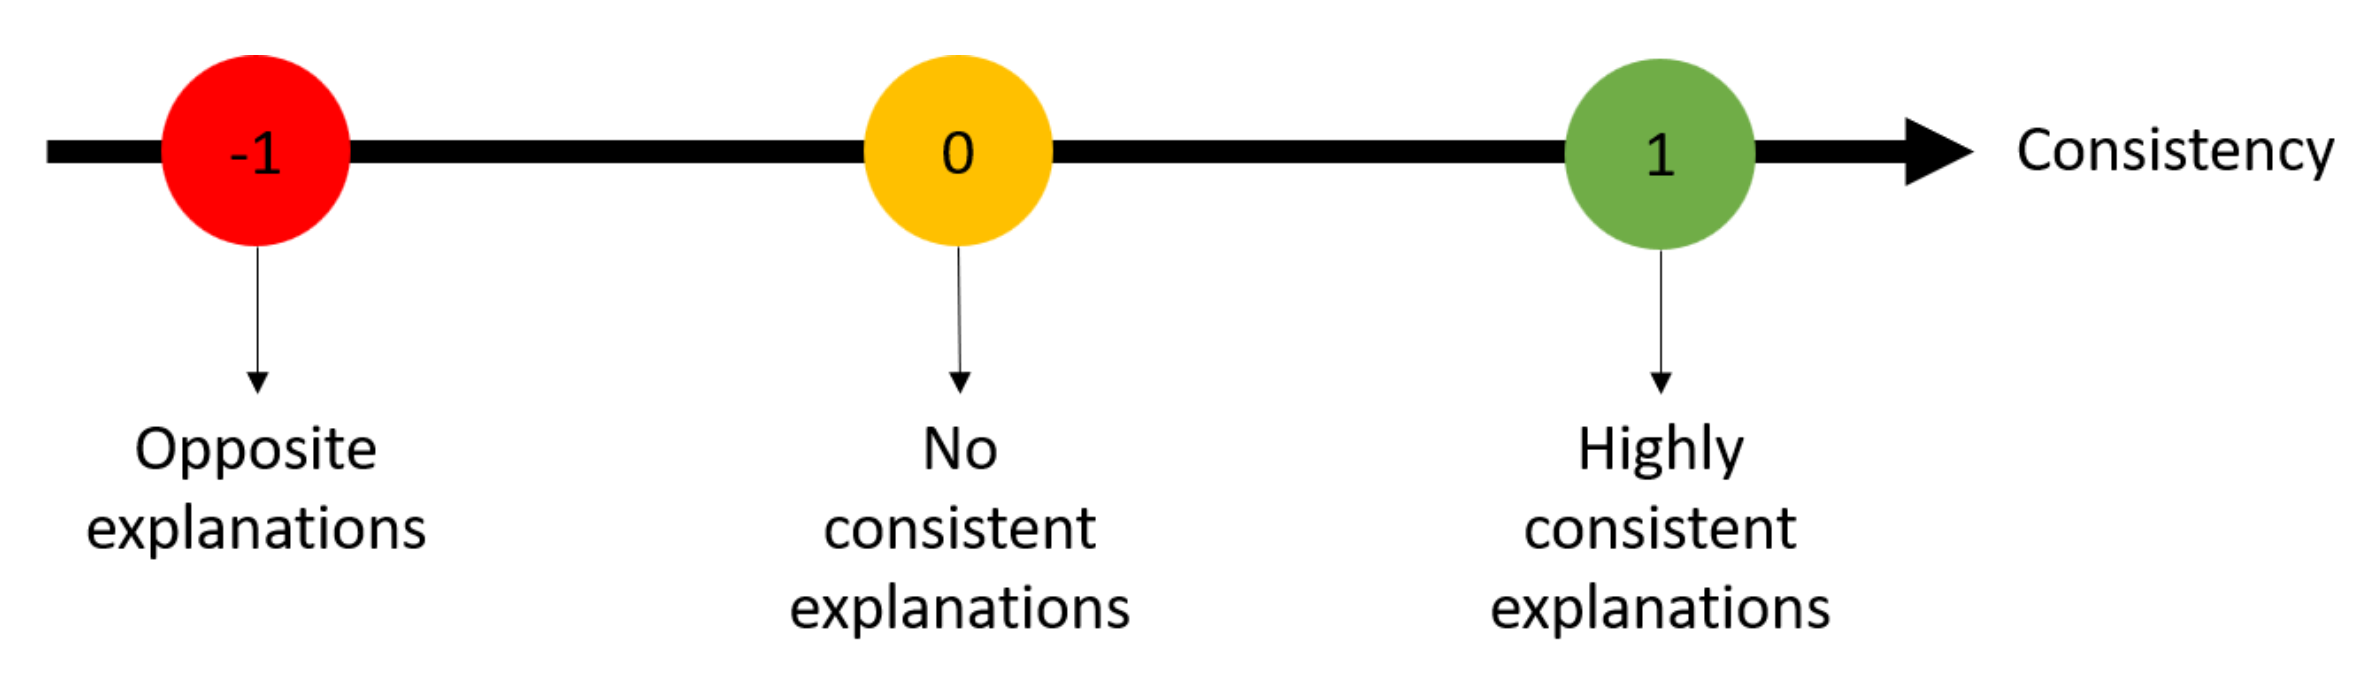

In [1]:
# Using 'admissions.csv' dataset

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

df = pd.read_csv('admission_data.csv')

# Handle missing values
imputer = SimpleImputer(strategy="mean")
df[['LOR']] = imputer.fit_transform(df[['LOR']])

# Select features and target (classification)
X = df.drop(['Accept'], axis=1)
y = df['Accept']

In [2]:
# ===== First train-test split =====
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

# Train model1
model1 = RandomForestClassifier(random_state=42)
model1.fit(X1_train_scaled, y1_train)

# Predict and evaluate model1
y1_pred = model1.predict(X1_test_scaled)
print("=== Model 1 ===")
print("Accuracy:", accuracy_score(y1_test, y1_pred))
print(classification_report(y1_test, y1_pred))

=== Model 1 ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        45
           1       1.00      1.00      1.00        55

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



In [3]:
# ===== Second train-test split =====
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=99)

# Scale features
scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

# Train model2
model2 = RandomForestClassifier(random_state=99)
model2.fit(X2_train_scaled, y2_train)

# Predict and evaluate model2
y2_pred = model2.predict(X2_test_scaled)
print("\n=== Model 2 ===")
print("Accuracy:", accuracy_score(y2_test, y2_pred))
print(classification_report(y2_test, y2_pred))


=== Model 2 ===
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        66

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



### Computing Consistency

In [9]:
import numpy as np
import shap
from sklearn.metrics.pairwise import cosine_similarity

# SHAP explainers
explainer1 = shap.TreeExplainer(model1)
explainer2 = shap.TreeExplainer(model2)

# Compute SHAP values on scaled training data
shap_values1 = explainer1.shap_values(X1_train_scaled)
shap_values2 = explainer2.shap_values(X2_train_scaled)

# Handle case when shap_values is a list (e.g., for classification)
# Use class 1 (positive class) if it's a binary classifier
if isinstance(shap_values1, list):
    shap_values1 = shap_values1[1]  # shape: (n_samples, n_features)
    shap_values2 = shap_values2[1]

# Sanity check to ensure 2D
print("shap_values1 shape:", shap_values1.shape)
print("shap_values2 shape:", shap_values2.shape)

# Compute mean absolute SHAP values per feature
feature_importance1 = np.mean(np.abs(shap_values1), axis=0).reshape(1, -1)
feature_importance2 = np.mean(np.abs(shap_values2), axis=0).reshape(1, -1)

# Final sanity check before cosine similarity
print("feature_importance1 shape:", feature_importance1.shape)
print("feature_importance2 shape:", feature_importance2.shape)

# Compute cosine similarity
consistency = cosine_similarity(feature_importance1, feature_importance2)

print("Cosine similarity between SHAP feature importances (consistency):", consistency[0][0])


shap_values1 shape: (400, 7, 2)
shap_values2 shape: (400, 7, 2)
feature_importance1 shape: (1, 14)
feature_importance2 shape: (1, 14)
Cosine similarity between SHAP feature importances (consistency): 0.9996639501376863


In [10]:
# draft code

# from sklearn.metrics.pairwise import cosine_similarity

# explainer1 = shap.TreeExplainer(model1)
# explainer2 = shap.TreeExplainer(model2)

# shap_values1 = explainer1.shap_values(X1_train_scaled)
# shap_values2 = explainer2.shap_values(X2_train_scaled)

# feature_importance1 = np.mean(np.abs(shap_values1), axis=0)
# feature_importance2 = np.mean(np.abs(shap_values2), axis=0)

# consistency = cosine_similarity([feature_importance1], [feature_importance2])

# print("Consistency between SHAP values:", consistency)

In [ ]:
# training ver 1

# # Calculate SHAP values and feature importance for model1
# explainer1 = shap.TreeExplainer(model1)
# shap_values1 = explainer1.shap_values(X1)
# feature_importance1 = np.mean(np.abs(shap_values1), axis=0)

# # Calculate SHAP values and feature importance for model2
# explainer2 = shap.TreeExplainer(model2)
# shap_values2 = explainer2.shap_values(X2)
# feature_importance2 = np.mean(np.abs(shap_values2), axis=0)

# # Consistency calculation
# consistency = cosine_similarity([feature_importance1], [feature_importance2])
# print("Consistency between SHAP values:", consistency)

### Faithfulness
- Evaluates if important features influence model's predictions
- Low faithfulness → misleads trust in modelreasoningUseful in sensitive applications
- Useful in sensitive applications

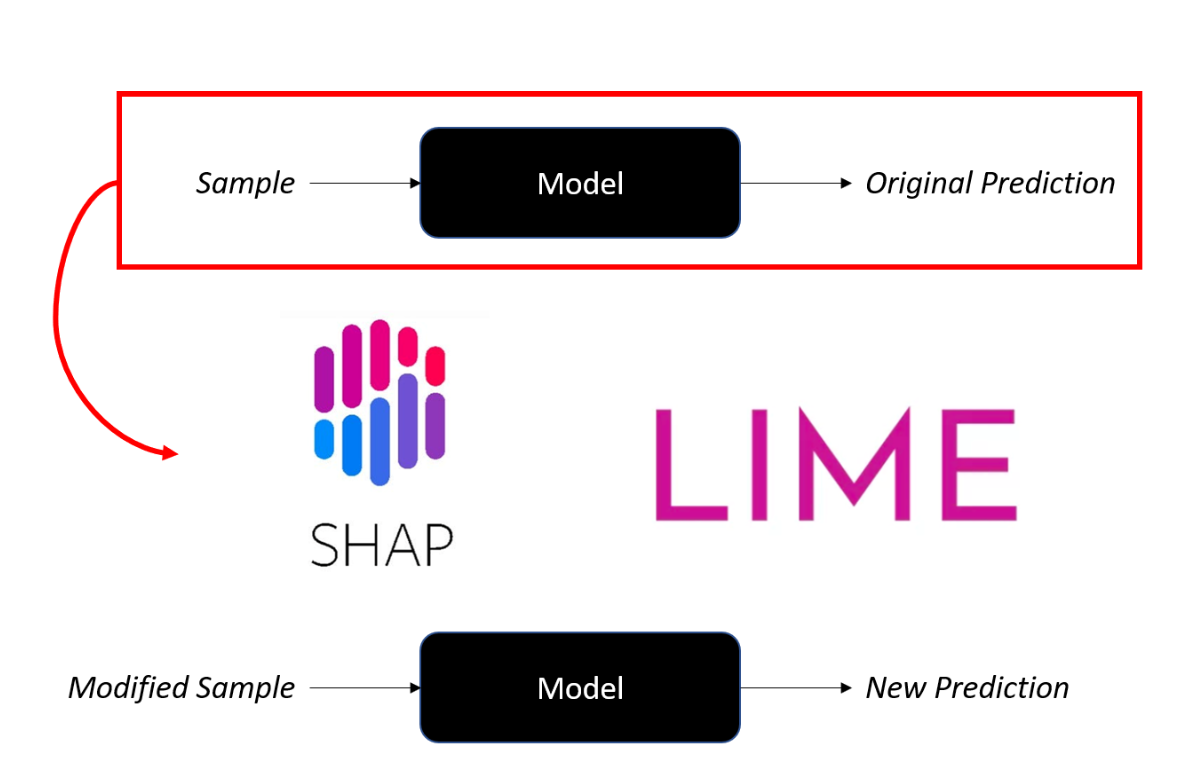

In [15]:
import lime.lime_tabular

# Original code
# X_instance = X_test.iloc[[0]]
# original_prediction = model.predict_proba(X_instance)[0, 1]

# print(f"Original prediction: {original_prediction}"

# Use the unscaled X_train for LIME since LIME works with original (not scaled) features
X_train_array = X1_train.values  # unscaled

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_array,
    feature_names=X.columns.tolist(),
    class_names=["Rejected", "Accepted"],
    mode="classification"
)

# Select one instance from the test set
X_instance = X1_test.iloc[[0]]  # unscaled, single row
X_instance_array = X_instance.values[0]

# Get original prediction (on scaled version)
original_prediction = model1.predict_proba(scaler1.transform(X_instance))[0, 1]
print(f"Original prediction: {original_prediction:.4f}")

Original prediction: 1.0000


### Computing Faithfulness

In [22]:
# Generate explanation
exp = explainer.explain_instance(
    data_row=X_instance_array,
    predict_fn=lambda x: model1.predict_proba(scaler1.transform(x)),
    num_features=5
)

# Display explanation
print("LIME Explanation:")
for feature, weight in exp.as_list():
    print(f"{feature}: {weight:.4f}")

# Get original prediction
X_instance = X1_test.iloc[[0]].copy()
X_instance_scaled = scaler1.transform(X_instance)
original_prediction = model1.predict_proba(X_instance_scaled)[0, 1]
print(f"Original prediction: {original_prediction:.4f}")

# Perturb important feature
X_instance['GRE Score'] = 310

# Predict again with perturbed input
X_instance_scaled_perturbed = scaler1.transform(X_instance)
new_prediction = model1.predict_proba(X_instance_scaled_perturbed)[0, 1]
print(f"Prediction after perturbing GRE Score: {new_prediction:.4f}")

# Compute local faithfulness
faithfulness_score = np.abs(original_prediction - new_prediction)
print(f"Local Faithfulness Score: {faithfulness_score:.4f}")

LIME Explanation:
Chance of Admit > 0.82: 0.4405
GRE Score > 324.25: 0.0585
CGPA > 9.04: 0.0426
TOEFL Score > 112.00: 0.0405
3.00 < University Rating <= 4.00: -0.0134
Original prediction: 1.0000
Prediction after perturbing GRE Score: 0.9700
Local Faithfulness Score: 0.0300


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# X_instance['GRE Score'] = 310

# new_prediction = model.predict_proba(X_instance)[0, 1]
# print(f"Prediction after perturbing {important_feature}: {new_prediction}")
# faithfulness_score = np.abs(original_prediction - new_prediction)

# print(f"Local Faithfulness Score: {faithfulness_score}")

In [ ]:
# training ver 2

# original_prediction = model.predict_proba(X_instance)[0, 1]
# print(f"Original prediction: {original_prediction}")

# # Change the gender value to 0 
# X_instance['gender'] = 0

# # Generate the new prediction
# new_prediction = model.predict_proba(X_instance)[0, 1]
# print(f"Prediction after perturbing 'gender': {new_prediction}")

# # Estimate faithfulness
# faithfulness_score = np.abs(original_prediction - new_prediction)
# print(f"Local Faithfulness Score: {faithfulness_score}")

### Explaining Unsupervised Models

#### Clustering
- Group similar data points without pre-defined labels

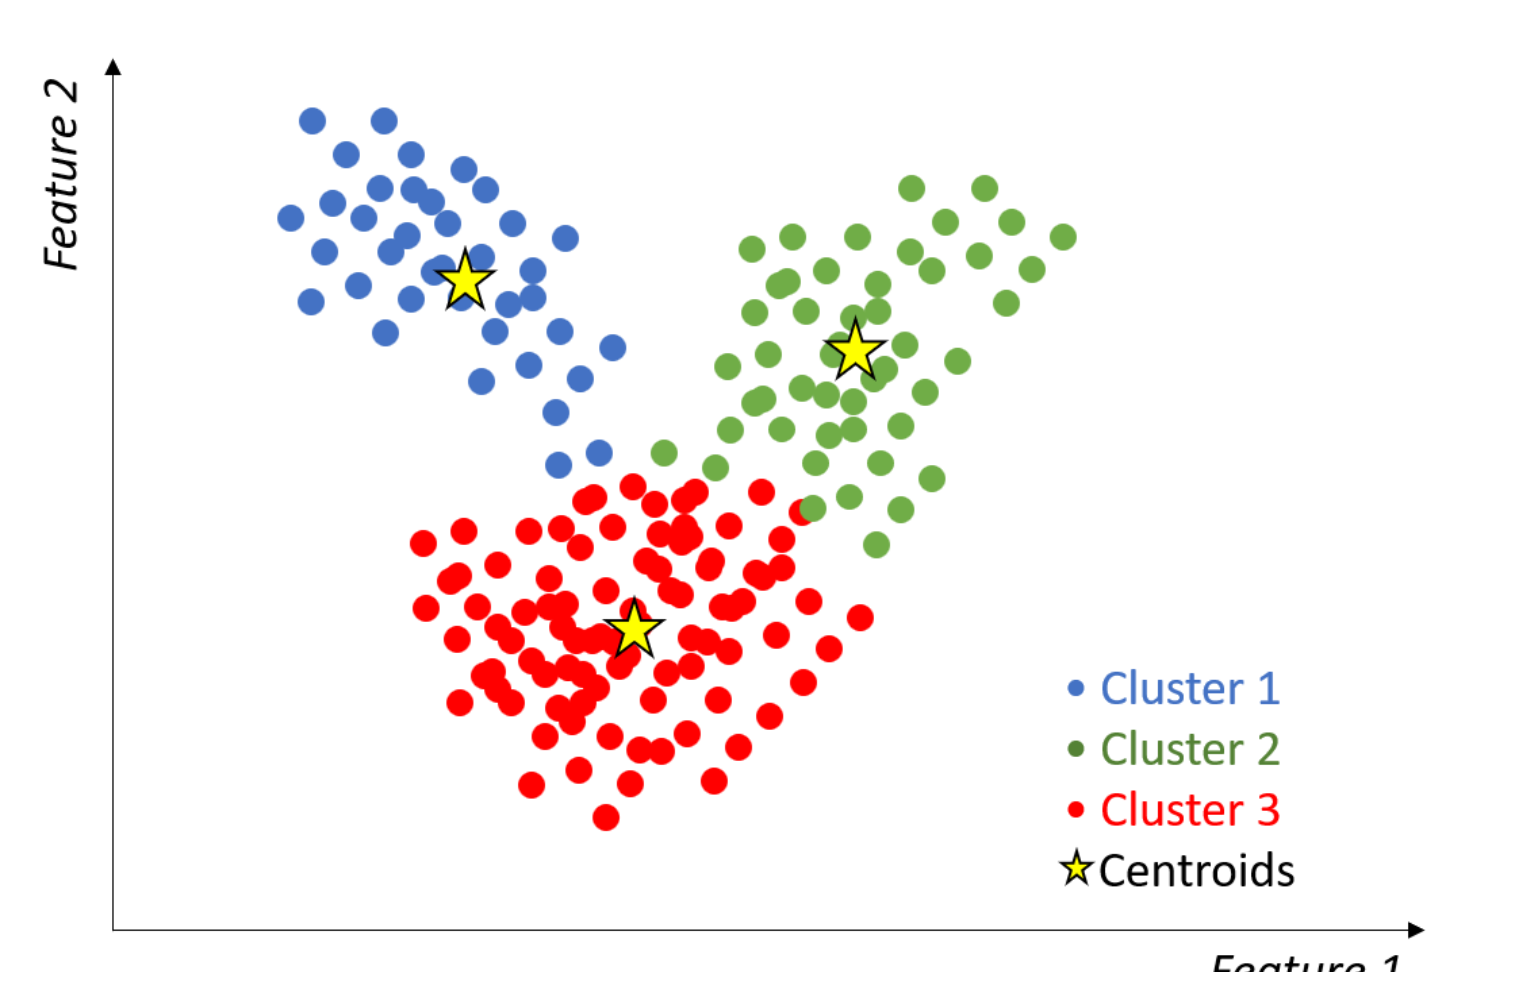

#### Silhouette Score
- Measures clustering's quality
- Ranges from -1 to 1
  - 1 → well-separated clusters

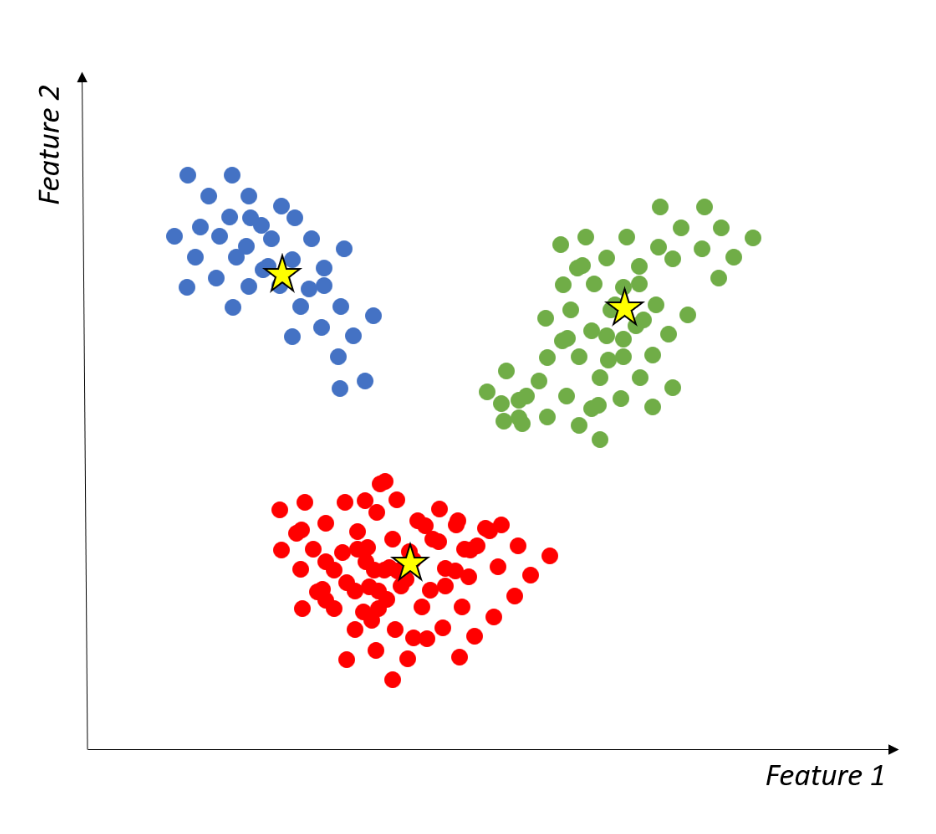

  - -1 → points incorrectly assigned
    
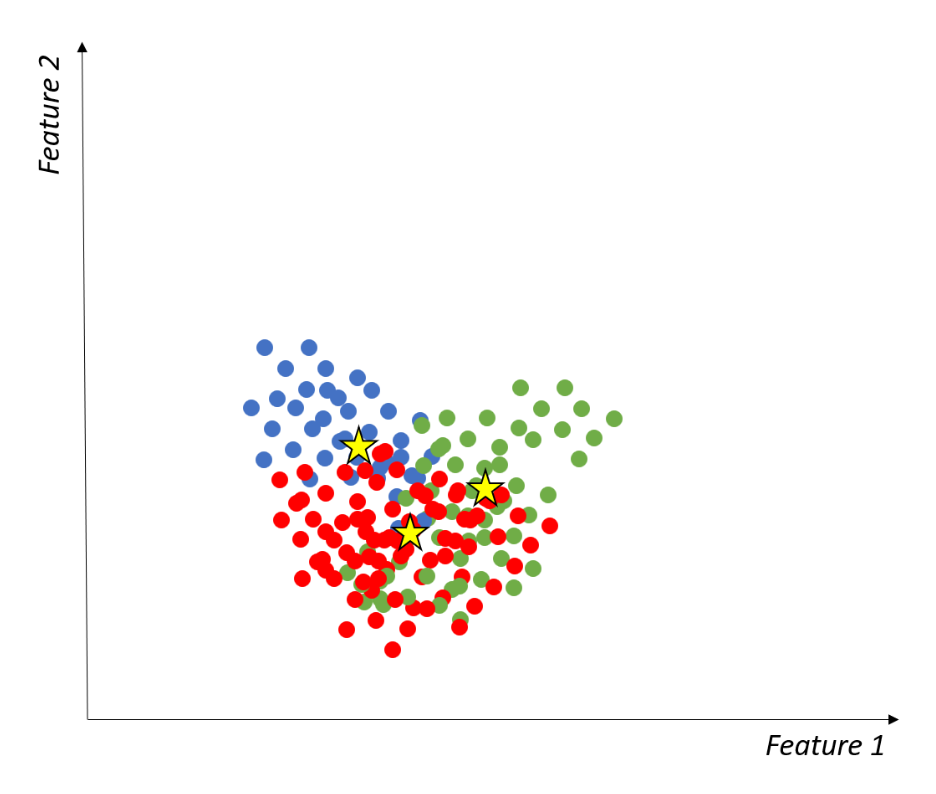

#### Feature impact on cluster quality

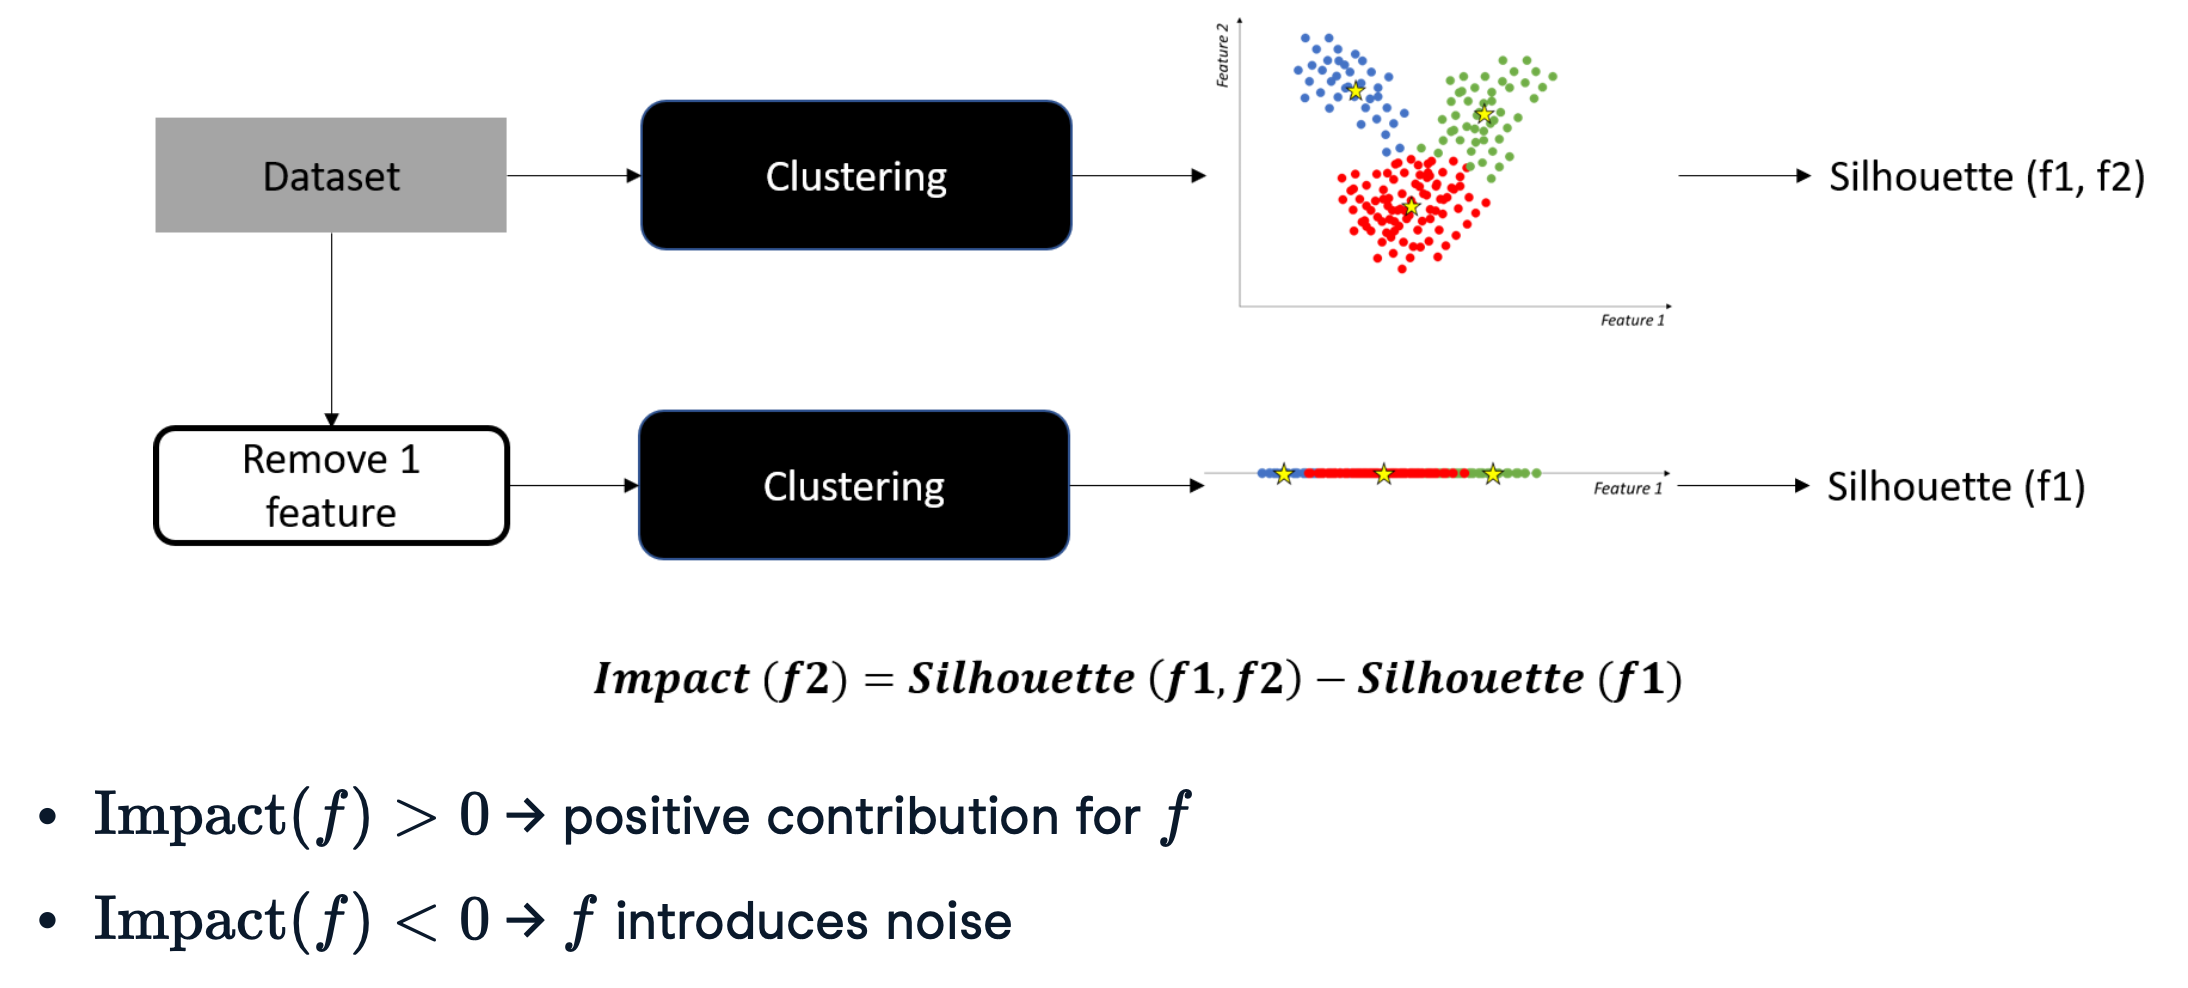

In [23]:
df1 = pd.read_csv('student_performance.csv')

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Use only the specified columns
selected_columns = ['age', 'health', 'absences', 'G1', 'G2', 'G3']
X = df1[selected_columns].values
column_names = selected_columns

### Computing feature impact on cluster quality

In [24]:
# Apply KMeans clustering
kmeans = KMeans(n_clusters=2, random_state=42).fit(X)
original_score = silhouette_score(X, kmeans.labels_)

# Evaluate feature importance based on silhouette score drop
impact_results = []
for i in range(X.shape[1]):
    X_reduced = np.delete(X, i, axis=1)
    kmeans.fit(X_reduced)
    new_score = silhouette_score(X_reduced, kmeans.labels_)
    impact = original_score - new_score
    impact_results.append((column_names[i], impact))

impact_results

[('age', -0.007311188306014849),
 ('health', -0.01753752109032153),
 ('absences', -0.11130267520211329),
 ('G1', -0.0692363458717058),
 ('G2', -0.05684114648660171),
 ('G3', -0.10887026077782436)]

### Adjusted rand index (ARI)
- Measures how well cluster assignments match

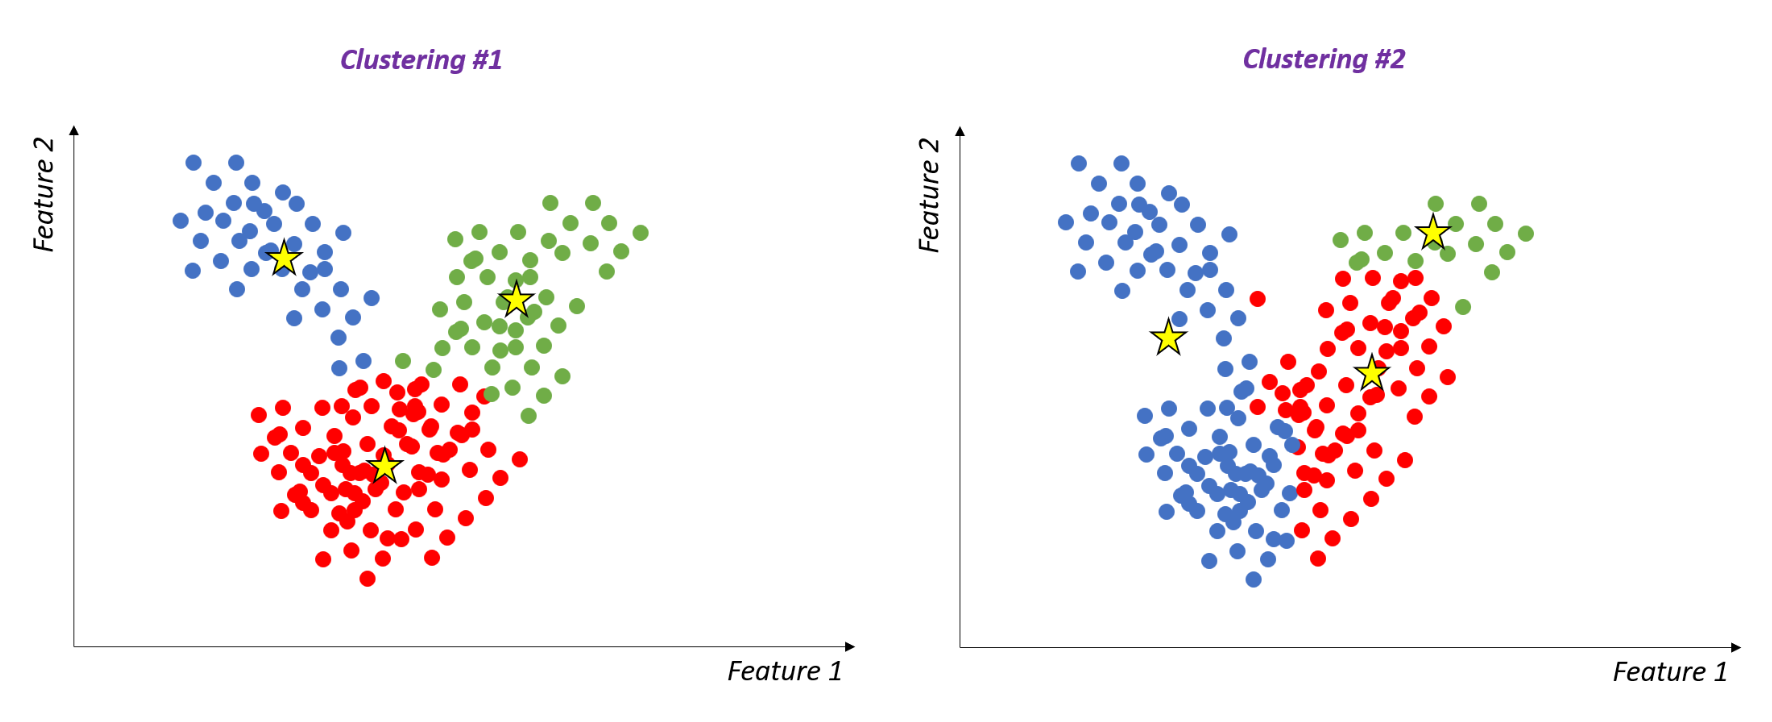
  
- Maximum ARI = 1 → perfect cluster alignment
- Lower ARI → greater difference in clusterings

### Feature importance for cluster assignments
- Remove features one at a time
- Importance(f) = 1 − ARI (original clusters, modifed clusters)
- Low (ARI) → high (1 − ARI) → important feature

### Feature importance for cluster assignment

In [25]:
from sklearn.metrics import adjusted_rand_score

kmeans = KMeans(n_clusters=2).fit(X)
original_clusters = kmeans.predict(X)

for i in range(X.shape[1]):    
    X_reduced = np.delete(X, i, axis=1)    
    reduced_clusters = kmeans.fit_predict(X_reduced)    
    importance = 1 - adjusted_rand_score(original_clusters, reduced_clusters)
    print(f'{df.columns[i]}: {importance}')

GRE Score: 0.15973235021739263
TOEFL Score: 0.19889491085959354
University Rating: 0.35113701705035194
SOP: 0.8904934716369484
LOR: 0.6638936464747205
CGPA: 0.8904934716369484


In [26]:
# training ver 3

# kmeans = KMeans(n_clusters=5, random_state=10, n_init=10).fit(X)
# # Derive the original silhouette score
# original_score = silhouette_score(X, kmeans.labels_)

# for i in range(X.shape[1]):
#   	# Remove feature at index i
#     X_reduced = np.delete(X, i, axis=1)
#     kmeans.fit(X_reduced)
#     # Compute the new silhouette score
#     new_score = silhouette_score(X_reduced, kmeans.labels_)
#     # Compute the feature's impact
#     impact = original_score - new_score
#     print(f'Feature {column_names[i]}: Impact = {impact}')

# training ver 4

# kmeans = KMeans(n_clusters=5, random_state=10, n_init=10).fit(X)
# # Derive original clusters
# original_clusters = kmeans.predict(X)

# for i in range(X.shape[1]):
#   	# Remove feature at index i
#     X_reduced = np.delete(X, i, axis=1)
#     # Derive reduced clusters
#     reduced_clusters = kmeans.fit_predict(X_reduced)
#     # Derive feature importance
#     importance = 1 - adjusted_rand_score(original_clusters,
#       reduced_clusters)
#     print(f'{column_names[i]}: {importance}')

In [ ]:
# training ver 5

# Complete the chain-of-thought prompt
# prompt = "In a basket, there are twice as many apples as oranges and three times as many oranges as bananas. If there are 6 bananas in the basket, how many fruits are there in total? Show your reasoning step-by-step."

# response = get_response(prompt)
# print(response)

In [ ]:
# training ver 6

# prompt = """Classify the following review as positive or negative. 
# You should reply with either "positive" or "negative", nothing else.
# Review: 'The coffee was excellent, but the service left much to be desired.'"""

# responses = []
# for i in range(5):
#     sentiment = get_response(prompt)
#     # Append the response to the responses list
#     responses.append(sentiment.lower())

# # Compute the confidence for each sentiment
# confidence = {
#     'positive': responses.count('positive') / len(responses),
#     'negative': responses.count('negative') / len(responses)
# }

# print(confidence)